In [37]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import style
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
style.use('ggplot')

In [4]:
file = "C:\\Users\\AlexanderChiu\\Desktop\\chicagocrime-elk\\Crimes_-_2001_to_present.csv"

In [5]:
df = pd.read_csv(file, encoding="ISO-8859-1")

### 数据清理

In [6]:
# 删除所有缺失的数据
crimes_df = df.dropna(how='any')

In [7]:
crimes_df.iloc[0]

ID                                         11859143
CaseNumber                                 JC470681
Date                         10/12/2019 11:58:00 PM
Block                                069XX S ADA ST
IUCR                                           1310
PrimaryType                         CRIMINAL DAMAGE
Description                             TO PROPERTY
LocationDescription                       APARTMENT
Arrest                                        False
Domestic                                      False
Beat                                            734
District                                          7
Ward                                              6
CommunityArea                                    67
FBICode                                          14
Xcoordinate                             1.16853e+06
Ycoordinate                              1.8587e+06
Year                                           2019
UpdatedOn                    10/19/2019 04:04:21 PM
Latitude    

In [8]:
# 删除不必要的列
crimes_df = df.drop(["field1","field2","field3","field4","field5","field6","field7","field8"],axis=1)

In [9]:
crimes_df.iloc[0]

ID                                         11859143
CaseNumber                                 JC470681
Date                         10/12/2019 11:58:00 PM
Block                                069XX S ADA ST
IUCR                                           1310
PrimaryType                         CRIMINAL DAMAGE
Description                             TO PROPERTY
LocationDescription                       APARTMENT
Arrest                                        False
Domestic                                      False
Beat                                            734
District                                          7
Ward                                              6
CommunityArea                                    67
FBICode                                          14
Xcoordinate                             1.16853e+06
Ycoordinate                              1.8587e+06
Year                                           2019
UpdatedOn                    10/19/2019 04:04:21 PM
Latitude    

In [11]:
crimes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990314 entries, 0 to 6990313
Data columns (total 22 columns):
ID                     int64
CaseNumber             object
Date                   object
Block                  object
IUCR                   object
PrimaryType            object
Description            object
LocationDescription    object
Arrest                 bool
Domestic               bool
Beat                   int64
District               float64
Ward                   float64
CommunityArea          float64
FBICode                object
Xcoordinate            float64
Ycoordinate            float64
Year                   int64
UpdatedOn              object
Latitude               float64
Longitude              float64
Location               object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 1.1+ GB


In [13]:
crimes = crimes_df

In [15]:
loc_to_change  = list(crimes['LocationDescription'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)

In [16]:
crimes.loc[crimes['LocationDescription'].isin(loc_to_change) , crimes.columns=='LocationDescription'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'

In [18]:
crimes['PrimaryType']         = pd.Categorical(crimes['PrimaryType'])
crimes['Location Description'] = pd.Categorical(crimes['LocationDescription'])
crimes['Description']          = pd.Categorical(crimes['Description'])

### 18年来月度变化

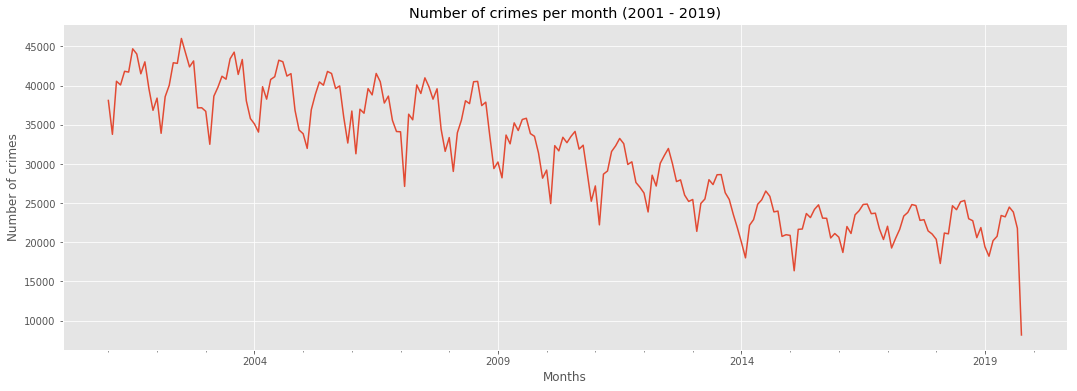

In [22]:
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)
plt.figure(figsize=(18,6))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2001 - 2019)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

### 各种犯罪类型 的数量变化

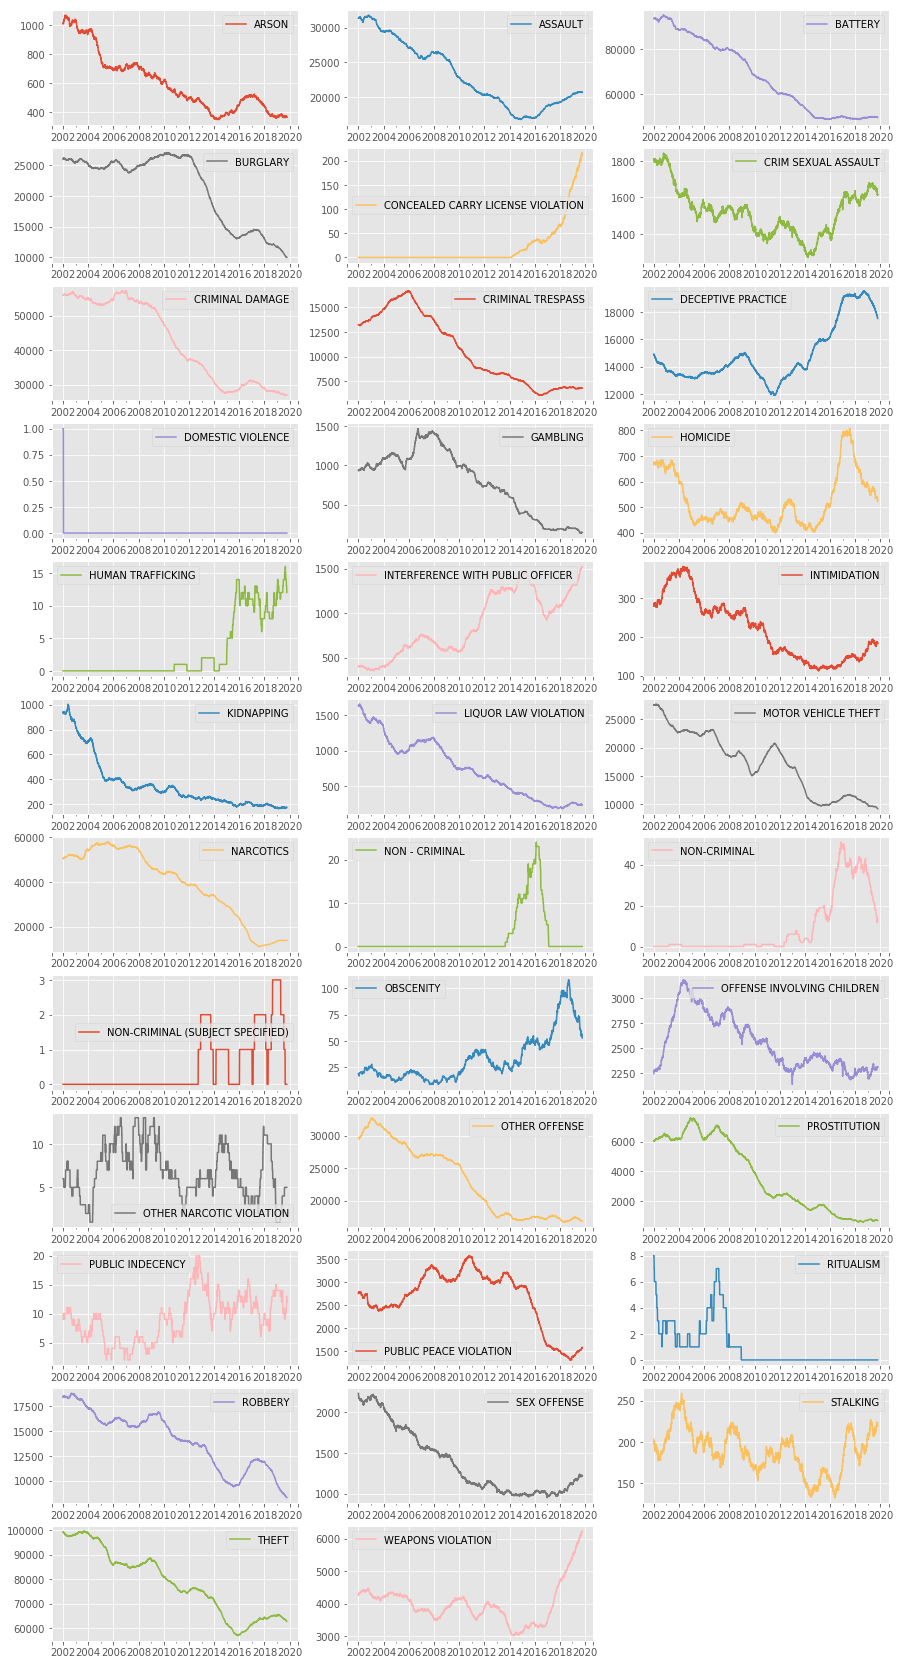

In [25]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='PrimaryType', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(15, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)


In [31]:


hour_by_location = crimes.pivot_table(values='ID', index='LocationDescription', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = crimes.pivot_table(values='ID', index='PrimaryType', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
#hour_by_week     = crimes.pivot_table(values='ID', index=crimes.index.hour, columns=crimes.index.weekday_name, aggfunc=np.size).fillna(0)
#hour_by_week     = hour_by_week[days].T # just reorder columns according to the the order of days
dayofweek_by_location = crimes.pivot_table(values='ID', index='LocationDescription', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = crimes.pivot_table(values='ID', index='PrimaryType', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = crimes.pivot_table(values='ID', index='LocationDescription', columns='PrimaryType', aggfunc=np.size).fillna(0)

In [34]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

E:\Annaconda\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


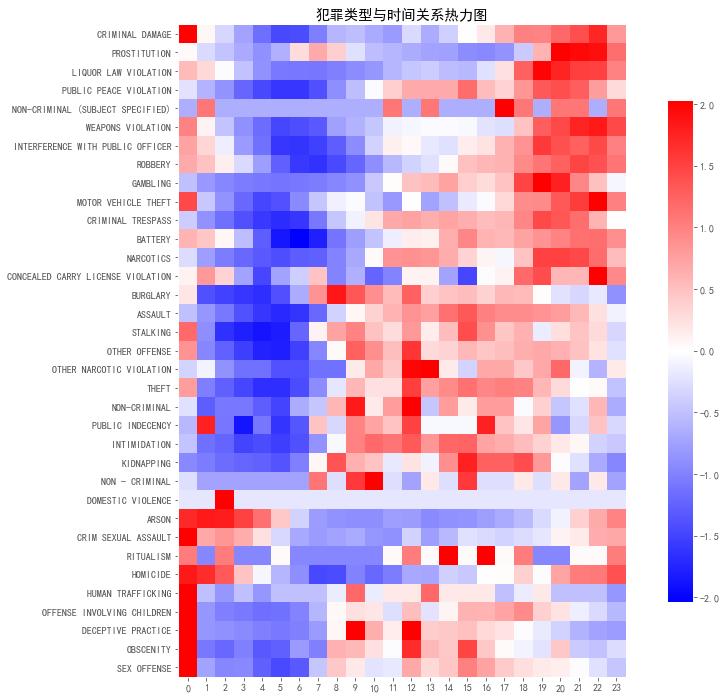

In [38]:
plt.figure(figsize=(15,12))
plt.title("犯罪类型与时间关系热力图")
scale_and_plot(hour_by_type)

E:\Annaconda\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


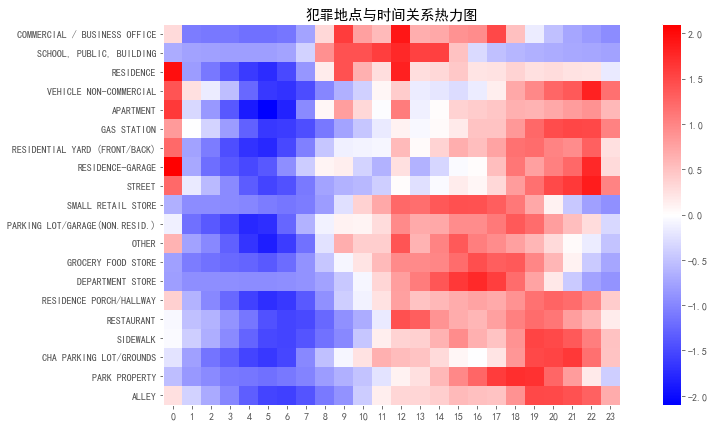

In [40]:
plt.figure(figsize=(15,7))
plt.title("犯罪地点与时间关系热力图")
scale_and_plot(hour_by_location)

E:\Annaconda\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


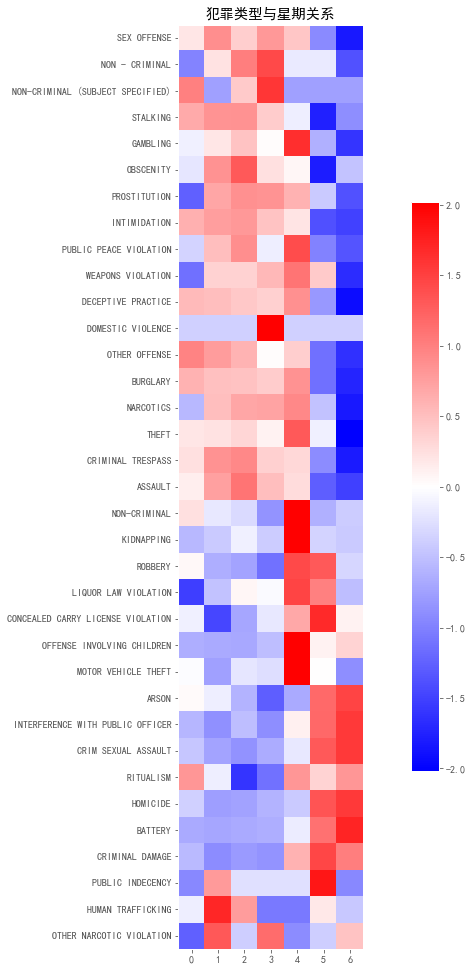

In [45]:
plt.figure(figsize=(17,17))
plt.title("犯罪类型与星期关系")
scale_and_plot(dayofweek_by_type)

E:\Annaconda\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


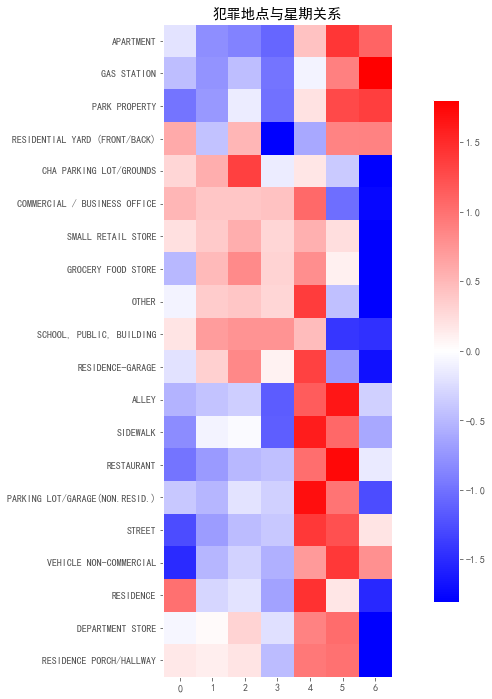

In [43]:
plt.figure(figsize=(15,12))
plt.title("犯罪地点与星期关系")
scale_and_plot(dayofweek_by_location)

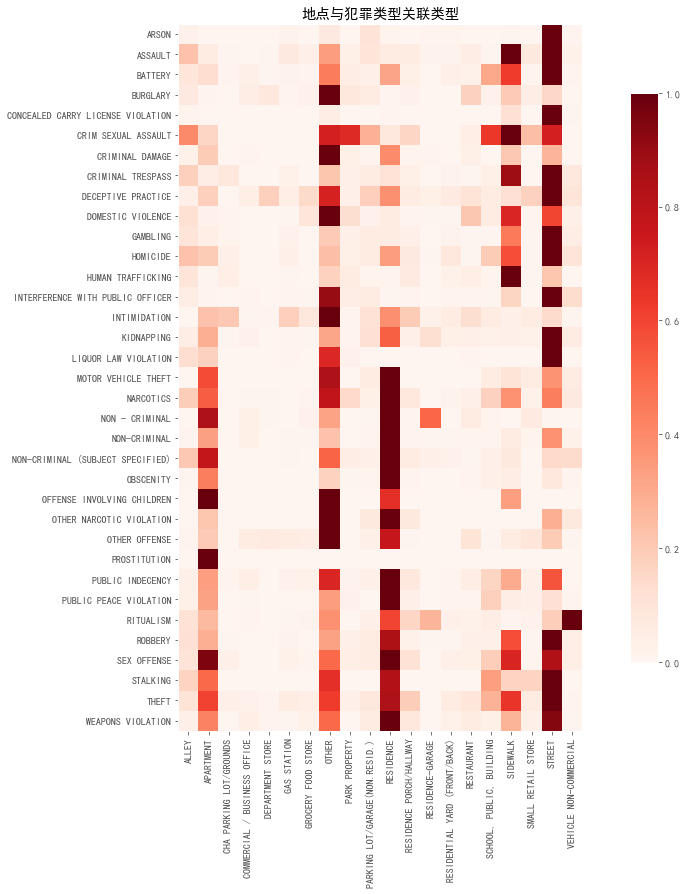

In [47]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('地点与犯罪类型关联类型')
plt.grid(False)
plt.show()

In [25]:
crimes_df = crimes_df.drop(['CaseNumber', 'IUCR', 'Arrest','Domestic','Beat',
                     'CommunityArea','FBICode', 'Xcoordinate', 'Ycoordinate', 
                     'UpdatedOn','Location', 'District'], axis = 1 )

In [10]:
crimes_df.iloc[0]

ID                                         11859143
CaseNumber                                 JC470681
Date                         10/12/2019 11:58:00 PM
Block                                069XX S ADA ST
IUCR                                           1310
PrimaryType                         CRIMINAL DAMAGE
Description                             TO PROPERTY
LocationDescription                       APARTMENT
Arrest                                        False
Domestic                                      False
Beat                                            734
District                                          7
Ward                                              6
CommunityArea                                    67
FBICode                                          14
Xcoordinate                             1.16853e+06
Ycoordinate                              1.8587e+06
Year                                           2019
UpdatedOn                    10/19/2019 04:04:21 PM
Latitude    

In [28]:
crimes_df = crimes_df[['ID','Date','Year','PrimaryType','Description', 'LocationDescription',
                       'Block','Ward','Latitude','Longitude']]

In [30]:
crimes_df['PrimaryType'].value_counts()

THEFT                                1475841
BATTERY                              1277930
CRIMINAL DAMAGE                       796246
NARCOTICS                             724396
ASSAULT                               437605
OTHER OFFENSE                         434274
BURGLARY                              397053
MOTOR VEHICLE THEFT                   322648
DECEPTIVE PRACTICE                    280962
ROBBERY                               263071
CRIMINAL TRESPASS                     199665
WEAPONS VIOLATION                      76460
PROSTITUTION                           68955
PUBLIC PEACE VIOLATION                 49240
OFFENSE INVOLVING CHILDREN             47728
CRIM SEXUAL ASSAULT                    28811
SEX OFFENSE                            26365
INTERFERENCE WITH PUBLIC OFFICER       16570
GAMBLING                               14556
LIQUOR LAW VIOLATION                   14274
ARSON                                  11492
HOMICIDE                                9942
KIDNAPPING

In [46]:
crimes_df["PrimaryType"] = crimes_df["PrimaryType"].replace({
     "THEFT": "THEFT & ROBBERY", "BURGLARY": "THEFT & ROBBERY", "MOTOR VEHICLE THEFT": "THEFT & ROBBERY",
     "ROBBERY": "THEFT & ROBBERY", "BATTERY": "ASSAULT", "CRIM SEXUAL ASSAULT": "ASSAULT", "PROSTITUTION": "SEX CRIMES",
     "SEX OFFENSE": "SEX CRIMES", "CRIMINAL TRESPASS": "CRIMINAL DAMAGE", "ARSON": "CRIMINAL DAMAGE", "OTHER OFFENSE":
     "OTHER OFFENSES", "DECEPTIVE PRACTICE": "OTHER OFFENSES", "WEAPONS VIOLATION": "OTHER OFFENSES", "GAMBLING":
     "OTHER OFFENSES", "STALKING": "OTHER OFFENSES", "KIDNAPPING": "OTHER OFFENSES", "OBSCENITY": "OTHER OFFENSES",
     "INTIMIDATION": "OTHER OFFENSES", "RITUALISM": "OTHER OFFENSES", "HUMAN TRAFFICKING": "OTHER OFFENSES",
     "CONCEALED CARRY LICENSE VIOLATION": "OTHER OFFENSES", "NON-CRIMINAL (SUBJECT SPECIFIED)": "OTHER OFFENSES",
     "NON-CRIMINAL": "OTHER OFFENSES", "PUBLIC PEACE VIOLATION": "OTHER OFFENSES", "OFFENSE INVOLVING CHILDREN":
     "OTHER OFFENSES", "INTERFERENCE WITH PUBLIC OFFICER": "OTHER OFFENSES", "LIQUOR LAW VIOLATION": "OTHER OFFENSES",
     "NON - CRIMINAL": "OTHER OFFENSES", "OTHER NARCOTIC VIOLATION": "NARCOTICS", "PUBLIC INDECENCY": "OTHER OFFENSES",
     "HOMICIDE": "ASSAULT" })


crimes_df['LocationDescription'] = crimes_df['LocationDescription'].replace({"SIDEWALK":"STREET", "ALLEY":"STREET",
            "APARTMENT":"RESIDENCE","RESIDENCE-GARAGE":"RESIDENCE","RESIDENCE PORCH/HALLWAY": 
            "RESIDENCE", "RESIDENTIAL YARD (FRONT/BACK)":"RESIDENCE","CHA APARTMENT": "RESIDENCE",
            "CHA HALLWAY/STAIRWELL/ELEVATOR": "RESIDENCE","SMALL RETAIL STORE":"RETAIL OUTLET","DRUG STORE":
            "RETAIL OUTLET","GAS STATION":"RETAIL OUTLET","DEPARTMENT STORE":"RETAIL OUTLET","RETAIL STORES":
            "RETAIL OUTLET","RESTAURANT":"BUSINESS","BAR OR TAVERN":"BUSINESS","RESTAURANT":"BUSINESS","BANK":
            "BUSINESS","HOTEL/MOTEL":"BUSINESS","VEHICLE NON-COMMERCIAL":"VEHICLE","PARKING LOT":"PUBLIC BUILDING/GROUNDS",
            "SCHOOL, PUBLIC, BUILDING":"SCHOOL","PARK PROPERTY":"PUBLIC BUILDING/GROUNDS","CTA PLATFORM":
            "PUBLIC BUILDING/GROUNDS","CHA PARKING LOT/GROUNDS":"PUBLIC BUILDING/GROUNDS","SCHOOL, PUBLIC, GROUNDS":
            "SCHOOL", "CTA TRAIN":"PUBLIC BUILDING/GROUNDS","VACANT LOT/LAND":"PUBLIC BUILDING/GROUNDS",
            "GROCERY FOOD STORE":"RETAIL OUTLET","PUBLIC HIGH SCHOOL":"SCHOOL",'CTA "L" TRAIN':
            "PUBLIC BUILDING/GROUNDS","PARKING LOT/GARAGE(NON.RESID.)":"PUBLIC BUILDING/GROUNDS","CTA BUS":"VEHICLE",
            "TAVERN/LIQUOR STORE":"RETAIL OUTLET","HOSPITAL BUILDING/GROUNDS":"HOSPITAL",
            "POLICE FACILITY/VEH PARKING LOT":"POLICE BUILDING","CONVENIENCE STORE":
            "RETAIL OUTLET","CHURCH/SYNAGOGUE/PLACE OF WORSHIP":"CHURCH","GOVERNMENT BUILDING/PROPERTY":
            "FEDERAL BUILDING","SCHOOL, PRIVATE, BUILDING":"SCHOOL","GOVERNMENT BUILDING":
            "FEDERAL BUILDING","CONSTRUCTION SITE":"BUSINESS","WAREHOUSE":"BUSINESS","AIRCRAFT":"AIRPORT",
            "ABANDONED BUILDING":"OTHER","CTA GARAGE / OTHER PROPERTY":"PUBLIC BUILDING/GROUNDS","TAXICAB":"VEHICLE",
            "CTA BUS STOP":"PUBLIC BUILDING/GROUNDS","BARBERSHOP":"BUSINESS","CURRENCY EXCHANGE":"BUSINESS","LIBRARY":
            "PUBLIC BUILDING/GROUNDS","ATHLETIC CLUB":"PUBLIC BUILDING/GROUNDS","MEDICAL/DENTAL OFFICE":"BUSINESS",
            "FACTORY/MANUFACTURING BUILDING":"BUSINESS","COMMERCIAL / BUSINESS OFFICE":"BUSINESS","SCHOOL, PRIVATE, GROUNDS":
            "SCHOOL","CLEANING STORE":"RETAIL OUTLET","VEHICLE-COMMERCIAL":"VEHICLE","COLLEGE/UNIVERSITY GROUNDS":"SCHOOL",
            "DRIVEWAY - RESIDENTIAL":"RESIDENCE","SPORTS ARENA/STADIUM":"PUBLIC BUILDING/GROUNDS","CTA STATION":
            "PUBLIC BUILDING/GROUNDS","ATM (AUTOMATIC TELLER MACHINE)":"BUSINESS","DAY CARE CENTER":"SCHOOL","BUSINESS":
            "BUSINESS","CAR WASH":"BUSINESS","AUTO":"VEHICLE","COLLEGE/UNIVERSITY RESIDENCE HALL":"SCHOOL","MOVIE HOUSE/THEATER":
            "RETAIL OUTLET", "APPLIANCE STORE":"RETAIL OUTLET","HIGHWAY/EXPRESSWAY":"STREET","LAKEFRONT/WATERFRONT/RIVERBANK":
            "OTHER","AIRPORT TERMINAL UPPER LEVEL - SECURE AREA":"AIRPORT","AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA":
            "AIRPORT","AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA":"AIRPORT","AIRPORT VENDING ESTABLISHMENT":"AIRPORT",
            "AIRPORT TERMINAL LOWER LEVEL - SECURE AREA":"AIRPORT","AIRPORT BUILDING NON-TERMINAL - SECURE AREA":"AIRPORT",
            "DELIVERY TRUCK":"VEHICLE","ANIMAL HOSPITAL":"HOSPITAL","AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA":"AIRPORT",
            "AIRPORT PARKING LOT":"AIRPORT","OTHER COMMERCIAL TRANSPORTATION":"VEHICLE","VEHICLE - OTHER RIDE SERVICE":"VEHICLE",
            "CREDIT UNION":"BUSINESS","AIRPORT EXTERIOR - NON-SECURE AREA":"AIRPORT","HOUSE":"RESIDENCE","AIRPORT EXTERIOR - SECURE AREA":
            "AIRPORT", "POOL ROOM":"OTHER","COIN OPERATED MACHINE":"OTHER","PAWN SHOP":"OTHER","YARD":"OTHER","BOWLING ALLEY":"OTHER",
            "BOAT/WATERCRAFT":"OTHER","BRIDGE":"STREET","CEMETERY":"PUBLIC BUILDING/GROUNDS","FOREST PRESERVE":
            "OTHER","SAVINGS AND LOAN":"BUSINESS","VACANT LOT":"OTHER","GANGWAY":"AIRPORT","PUBLIC BUILDING/GROUND":"PUBLIC BUILDING/GROUNDS",
            "VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)":"VEHICLE","PORCH":"RESIDENCE","NEWSSTAND":"STREET","RETAIL STORE":"RETAIL OUTLET",
            "AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA":"AIRPORT","AIRPORT TRANSPORTATION SYSTEM (ATS)":"AIRPORT","HALLWAY":"OTHER",
            "VEHICLE - DELIVERY TRUCK":"VEHICLE","AUTO / BOAT / RV DEALERSHIP":"BUSINESS","CEMETARY":"PUBLIC BUILDING/GROUNDS","GARAGE":"OTHER",
            "CTA TRACKS - RIGHT OF WAY":"OTHER","CHA PARKING LOT":"PUBLIC BUILDING/GROUNDS","GAS STATION DRIVE/PROP.":"RETAIL OUTLET",
            "CHA GROUNDS":"PUBLIC BUILDING/GROUNDS","TAVERN":"BUSINESS","BASEMENT":"RESIDENCE","CHA HALLWAY":"RESIDENCE","OFFICE":"BUSINESS",
            "DRIVEWAY":"RESIDENCE","VESTIBULE":"OTHER","STAIRWELL":"OTHER","HOTEL":"BUSINESS","CLUB":"BUSINESS","OFFICE":"BUSINESS","BARBER SHOP/BEAUTY SALON":
            "BUSINESS","SCHOOL YARD":"SCHOOL","RAILROAD PROPERTY":"PUBLIC BUILDING/GROUNDS","PUBLIC GRAMMAR SCHOOL":"SCHOOL","TRUCK":"VEHICLE","TAXI CAB":
            "VEHICLE","DUMPSTER":"VEHICLE","MOTEL":"BUSINESS","CHA LOBBY":"PUBLIC BUILDING/GROUNDS","CHA STAIRWELL":"PUBLIC BUILDING/GROUNDS",
            "GARAGE/AUTO REPAIR":"BUSINESS","LIQUOR STORE":"RETAIL OUTLET","NURSING HOME":"HOSPITAL","CTA PROPERTY":"PUBLIC BUILDING/GROUNDS","TRAILER":"OTHER",
            "YMCA":"OTHER","LAKE":"OTHER","VEHICLE-COMMERCIAL - TROLLEY BUS":"VEHICLE","VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS":"VEHICLE","RIVER":"OTHER",
            "KENNEL":"OTHER","FUNERAL PARLOR":"BUSINESS","BANQUET HALL":"OTHER","ROOMING HOUSE":"OTHER","LIVERY STAND OFFICE":"BUSINESS",
            "LAUNDRY ROOM":"OTHER","PRAIRIE":"OTHER","RIVER BANK":"OTHER","COACH HOUSE":"OTHER","SEWER":"OTHER","LAGOON":"OTHER","CLEANERS/LAUNDROMAT":"BUSINESS",
            "HORSE STABLE":"OTHER","FACTORY":"BUSINESS","CHA BREEZEWAY":"OTHER","CHA ELEVATOR":"PUBLIC BUILDING/GROUNDS","FARM":"OTHER","ELEVATOR":"OTHER",
            "POOLROOM":"OTHER","WOODED AREA":"OTHER","LOADING DOCK":"OTHER","TRUCKING TERMINAL":"OTHER","LIVERY AUTO":"BUSINESS","CHURCH PROPERTY":"CHURCH",
            "EXPRESSWAY EMBANKMENT":"STREET","CHA PLAY LOT":"PUBLIC BUILDING/GROUNDS",'CTA "L" PLATFORM':"PUBLIC BUILDING/GROUNDS","JUNK YARD/GARBAGE DUMP":
            "OTHER","COUNTY JAIL":"POLICE/FIRE STATION","JAIL / LOCK-UP FACILITY":"POLICE/FIRE STATION","POLICE BUILDING":"POLICE/FIRE STATION",
            "NURSING HOME/RETIREMENT HOME":"HOSPITAL", "FIRE STATION":"POLICE/FIRE STATION","OTHER RAILROAD PROP / TRAIN DEPOT":"PUBLIC BUILDING/GROUNDS","AIPORT/AIRCRAFT":
            "AIRPORT/AIRCRAFT","AIRPORT": "AIRPORT/AIRCRAFT","HOSPITAL":"PUBLIC BUILDING/GROUNDS","CHURCH":"OTHER","FEDERAL BUILDING":"PUBLIC BUILDING/GROUNDS",
            "POLICE/FIRE STATION":"PUBLIC BUILDING/GROUNDS","AIRPORT/AIRCRAFT":"PUBLIC BUILDING/GROUNDS","PUBLIC BUILDING/GROUNDS":"PUBLIC BLDG"                                        
            })


# Combine similar offenses together
crimes_df['Description'] = crimes_df["Description"].replace({"DOMESTIC VIOLENCE": "OTHER OFFENSES"
                                 })
crimes_df['PrimaryType'].value_counts()

THEFT & ROBBERY      2458613
ASSAULT              1754288
CRIMINAL DAMAGE      1007403
OTHER OFFENSES        950165
NARCOTICS             724524
SEX CRIMES             95320
DOMESTIC VIOLENCE          1
Name: PrimaryType, dtype: int64

In [47]:
### 对毒品犯罪的分析

drugs_crime_df = crimes_df.loc[crimes_df["PrimaryType"] == "NARCOTICS", :]

In [48]:
# Convert the Date column to a datetime type 
drugs_crime_df['Date'] = pd.to_datetime(drugs_crime_df['Date'])

# Separate the time element of the Date column into a new column 
drugs_crime_df['Time'] = drugs_crime_df['Date'].dt.time

# Separate the Month element of the Date column into a new column 
drugs_crime_df['Month'] = drugs_crime_df['Date'].dt.month

# Use list comprehension, Calender Module and apply function to convert month to a string object
drugs_crime_df['Month'] = drugs_crime_df['Month'].apply(lambda x: calendar.month_abbr[x])

E:\Annaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Annaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
E:\Annaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anna

In [49]:
drugs_crime_df['Description'].value_counts()

POSS: CANNABIS 30GMS OR LESS                           277842
POSS: CRACK                                            120545
POSS: HEROIN(WHITE)                                     94512
SOLICIT NARCOTICS ON PUBLICWAY                          27580
MANU/DELIVER: HEROIN (WHITE)                            25934
POSS: COCAINE                                           25219
MANU/DELIVER:CRACK                                      24751
ATTEMPT POSSESSION NARCOTICS                            21345
POSS: CANNABIS MORE THAN 30GMS                          18697
FOUND SUSPECT NARCOTICS                                 17410
MANU/DEL:CANNABIS OVER 10 GMS                           12102
MANU/DEL:CANNABIS 10GM OR LESS                          11797
POSSESSION OF DRUG EQUIPMENT                             8987
ATTEMPT POSSESSION CANNABIS                              4619
POSS: HALLUCINOGENS                                      4022
FORFEIT PROPERTY                                         3862
POSS: SY

In [55]:
drugs_crime_df['Description'].value_counts()

CANNABIS    392010
COCAINE     173181
HEROIN      123496
OTHERS       35837
Name: Description, dtype: int64

In [56]:
drugs_crime_df = drugs_crime_df[['ID','Date','Year','Month','Time','PrimaryType','Description', 'LocationDescription',
                                 'Block','Ward','Latitude','Longitude']]

drugs_crime_df.head(2)

,ID,Date,Year,Month,Time,PrimaryType,Description,LocationDescription,Block,Ward,Latitude,Longitude
1,11859039,2019-10-12 23:57:00,2019,Oct,23:57:00,NARCOTICS,CANNABIS,PARKING LOT/GARAGE(NON.RESID.),039XX W MADISON ST,28.0,41.880748,-87.723882
7,11859015,2019-10-12 23:44:00,2019,Oct,23:44:00,NARCOTICS,CANNABIS,STREET,007XX N HAMLIN AVE,27.0,41.894431,-87.721159


In [62]:

# Combine similar offenses together
crimes_df['PrimaryType'] = crimes_df["PrimaryType"].replace({"DOMESTIC VIOLENCE": "OTHER OFFENSES"
                                 })
crimes_df['PrimaryType'].value_counts()

THEFT & ROBBERY    2458613
ASSAULT            1754288
CRIMINAL DAMAGE    1007403
OTHER OFFENSES      950166
NARCOTICS           724524
SEX CRIMES           95320
Name: PrimaryType, dtype: int64

### Visualization Analysis

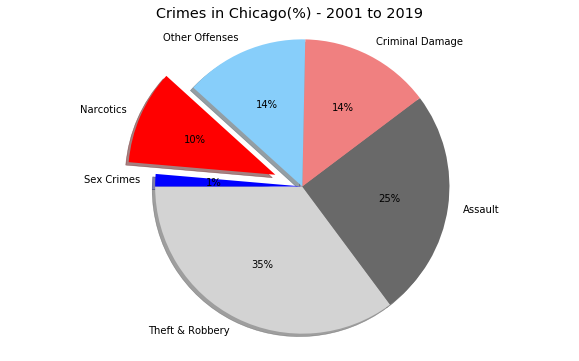

In [63]:
# Labels for the sections of our pie chart
labels = ['Theft & Robbery','Assault','Criminal Damage','Other Offenses','Narcotics',"Sex Crimes"]

# The colors of each section of the pie chart
colors = ["lightgray", "dimgray", "lightcoral", "lightskyblue", "red", "blue"]

# Tells matplotlib to seperate the "Narcotics" section from the others
explode = (0, 0, 0, 0, 0.2, 0)

# Set figure size
plt.figure(figsize=(10,6))

# Creates the pie chart based upon the values above
plt.pie(crimes_df['PrimaryType'].value_counts(), explode=explode, labels=labels, colors=colors,
        autopct="%1.0f%%", shadow=True, startangle= 180)

# Incorporate other chart properties
plt.axis("equal")
plt.title("Crimes in Chicago(%) - 2001 to 2019")

# Save the output
#plt.savefig("Chicago_crimes_Images\\Crimes_in_chicago.png")

plt.show()

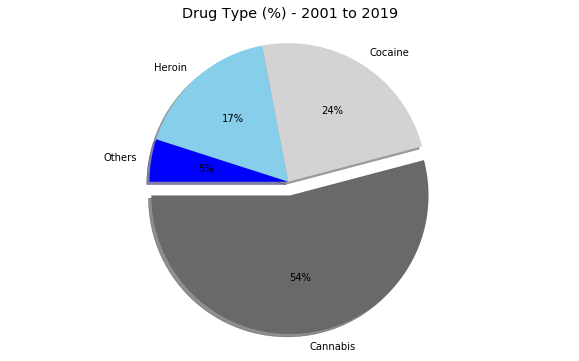

In [65]:

# Labels for the sections of our pie chart
labels = ['Cannabis','Cocaine','Heroin','Others']

# The colors of each section of the pie chart
colors = ["dimgrey", "lightgray", "skyblue", "blue"]

# Tells matplotlib to seperate the "Cannabis" section from the others
explode = (0.1, 0, 0, 0, )

# Set figure size
plt.figure(figsize=(10,6))

# Create the pie chart based upon the values above
plt.pie(drugs_crime_df['Description'].value_counts(), explode=explode, labels=labels, colors=colors,
        autopct="%1.0f%%", shadow=True, startangle= 180)

# Incorporate other chart properties
plt.axis("equal")
plt.title("Drug Type (%) - 2001 to 2019")

# Save the output
#plt.savefig("Chicago_crimes_Images\\Drug_crimes_chicago.png")

plt.show()

In [70]:
# Filter the data so that only those listd as 'Theft & Robbery' are in a DataFrame
theft_crimes_df = crimes_df.loc[crimes_df["PrimaryType"] == "THEFT & ROBBERY", :]
theft_crimes_year = pd.DataFrame({"No. of Theft Crimes":theft_crimes_df.groupby(['Year'])['PrimaryType'].count()})
# Reset index and sort values by Year
theft_crimes_year = theft_crimes_year.reset_index()
theft_crimes_year = theft_crimes_year.sort_values('Year', ascending=True)


# Filter the data so that only those listd as 'Assault' are in a DataFrame
assault_crimes_df = crimes_df.loc[crimes_df["PrimaryType"] == "ASSAULT", :]
assault_crimes_year = pd.DataFrame({"No. of Assault Crimes":assault_crimes_df.groupby(['Year'])['PrimaryType'].count()})
# Reset index and sort values by Year
assault_crimes_year = assault_crimes_year.reset_index()
assault_crimes_year = assault_crimes_year.sort_values('Year', ascending=True)


# Filter the data so that only those listd as 'Criminal Damage' are in a DataFrame
damage_crimes_df = crimes_df.loc[crimes_df["PrimaryType"] == "CRIMINAL DAMAGE", :]
damage_crimes_year = pd.DataFrame({"No. of Damage Crimes":damage_crimes_df.groupby(['Year'])['PrimaryType'].count()})
# Reset index and sort values by Year
damage_crimes_year = damage_crimes_year.reset_index()
damage_crimes_year = damage_crimes_year.sort_values('Year', ascending=True)


# Filter the data so that only those listd as 'Other Offenses' are in a DataFrame
other_crimes_df = crimes_df.loc[crimes_df["PrimaryType"] == "OTHER OFFENSES", :]
other_crimes_year = pd.DataFrame({"No. of Other Offense Crimes":other_crimes_df.groupby(['Year'])['PrimaryType'].count()})
# Reset index and sort values by Year
other_crimes_year = other_crimes_year.reset_index()
other_crimes_year = other_crimes_year.sort_values('Year', ascending=True)


# Filter the data so that only those listd as 'Sex Crimes' are in a DataFrame
sex_crimes_df = crimes_df.loc[crimes_df["PrimaryType"] == "SEX CRIMES", :]
sex_crimes_year = pd.DataFrame({"No. of Sex Crimes":sex_crimes_df.groupby(['Year'])['PrimaryType'].count()})
# Reset index and sort values by Year
sex_crimes_year = sex_crimes_year.reset_index()
sex_crimes_year = sex_crimes_year.sort_values('Year', ascending=True)


# Create a Dataframe with Year and count of Primary Type
drugs_crime_year = pd.DataFrame({"No. of Drug Crimes":drugs_crime_df.groupby(['Year'])['PrimaryType'].count()})
# Reset index and sort values by Year
drugs_crime_year = drugs_crime_year.reset_index()
drugs_crime_year = drugs_crime_year.sort_values('Year', ascending=True)
                              
drugs_crime_year.tail()

,Year,No. of Drug Crimes
14,2015,23940
15,2016,13310
16,2017,11673
17,2018,13407
18,2019,11105


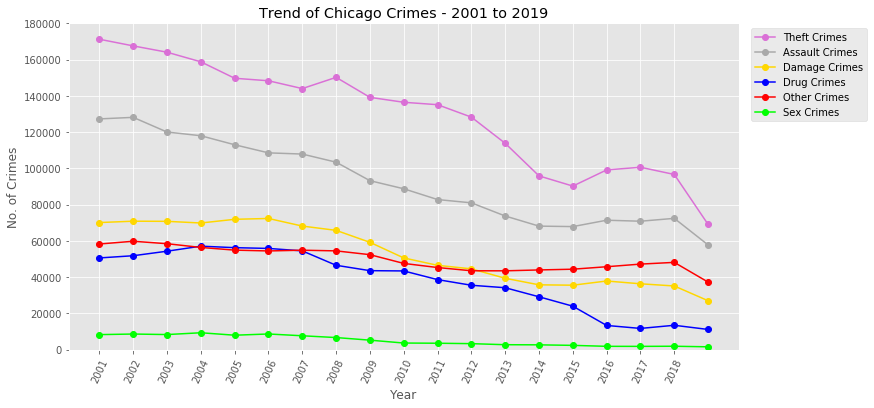

In [72]:
# Set figure size
plt.figure(figsize=(12,6))

# Create line graphs for each crime
plt.plot(theft_crimes_year['Year'], theft_crimes_year['No. of Theft Crimes'], marker ='o', 
         color='orchid', label="Theft Crimes")

plt.plot(assault_crimes_year['Year'], assault_crimes_year['No. of Assault Crimes'], marker ='o',
         color='darkgrey', label="Assault Crimes")

plt.plot(damage_crimes_year['Year'], damage_crimes_year['No. of Damage Crimes'], marker ='o',
         color='gold', label="Damage Crimes")

plt.plot(drugs_crime_year['Year'], drugs_crime_year['No. of Drug Crimes'], marker ='o', 
         color='blue', label="Drug Crimes")

plt.plot(other_crimes_year['Year'], other_crimes_year['No. of Other Offense Crimes'], marker ='o',
         color='red', label="Other Crimes")

plt.plot(sex_crimes_year['Year'], sex_crimes_year['No. of Sex Crimes'], marker ='o', 
         color='lime', label="Sex Crimes")


# Incorporate other graph properties
plt.title('Trend of Chicago Crimes - 2001 to 2019')
plt.xlabel("Year")
plt.ylim(0,180000)
plt.ylabel("No. of Crimes")
plt.legend(bbox_to_anchor =[1.20,1])
plt.xticks(np.arange(2001,2019,1), rotation = 65)
plt.grid(True)
plt.show()

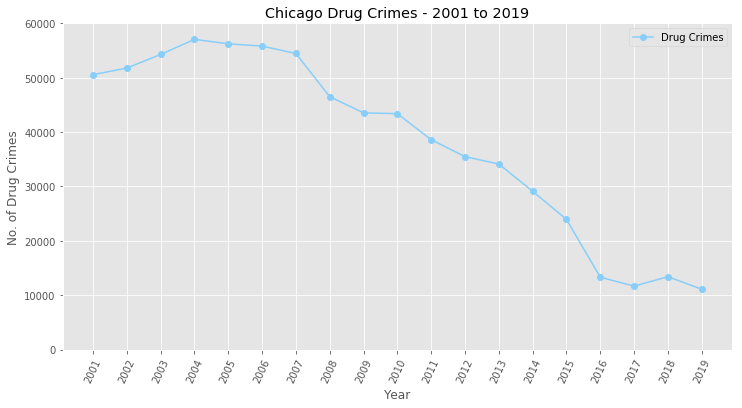

In [74]:

# Set figure size
plt.figure(figsize=(12,6))

# Plot the number of drug crimes per year
plt.plot(drugs_crime_year['Year'], drugs_crime_year['No. of Drug Crimes'], marker ='o', color='lightskyblue', label="Drug Crimes")

# Incorporate other graph properties
plt.title('Chicago Drug Crimes - 2001 to 2019')
plt.xlabel("Year")
plt.ylim(0,60000)
plt.ylabel("No. of Drug Crimes")
plt.legend(loc='best')
plt.xticks(np.arange(2001,2020,1), rotation = 65)
plt.grid(True)

# Save the output
# plt.savefig("Chicago_crimes_Images\\Chicago_drug_crimes.png")

plt.show()

## 毒品交易一般发生在什么地方？

In [84]:

#crimes_df['Location Description'].value_counts()
all_crime_locations = pd.DataFrame({"No. of Crimes":crimes_df['LocationDescription'].value_counts()})

all_crime_locations

,No. of Crimes
STREET,2664873
RESIDENCE,2326913
PUBLIC BLDG,547860
RETAIL OUTLET,460928
BUSINESS,326675
OTHER,299557
SCHOOL,203468
VEHICLE,154345


### 芝加哥所有犯罪的地点分布

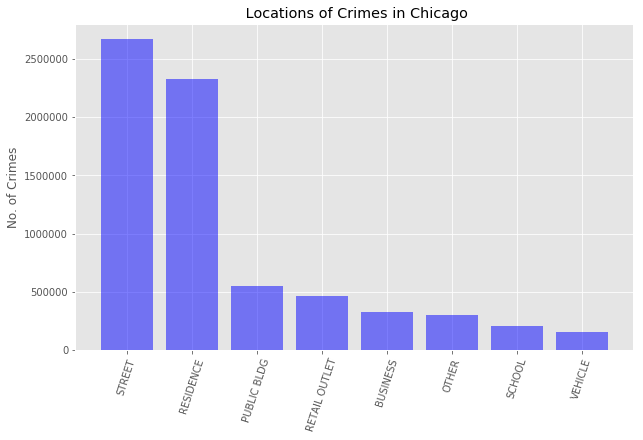

In [85]:
y_axis = all_crime_locations['No. of Crimes']
x_axis = all_crime_locations.index
color = ['blue']

# Set figure size
plt.figure(figsize=(10,6))

# Create a Bar plot  
plt.bar(x_axis, y_axis , color=color, alpha=0.5, align="center")

# Incorporate other chart properties
plt.title(" Locations of Crimes in Chicago")
plt.ylabel("No. of Crimes")
plt.xticks(rotation=72)
plt.grid(True)

# Save the output
# plt.savefig("Chicago_crimes_Images\\Crimes_locations_chicago.png")


In [90]:

drugs_crime_df['LocationDescription'] = drugs_crime_df['LocationDescription'].replace({"SIDEWALK":"STREET", "ALLEY":"STREET",
            "APARTMENT":"RESIDENCE","RESIDENCE-GARAGE":"RESIDENCE","RESIDENCE PORCH/HALLWAY": 
            "RESIDENCE", "RESIDENTIAL YARD (FRONT/BACK)":"RESIDENCE","CHA APARTMENT": "RESIDENCE",
            "CHA HALLWAY/STAIRWELL/ELEVATOR": "RESIDENCE","SMALL RETAIL STORE":"RETAIL OUTLET","DRUG STORE":
            "RETAIL OUTLET","GAS STATION":"RETAIL OUTLET","DEPARTMENT STORE":"RETAIL OUTLET","RETAIL STORES":
            "RETAIL OUTLET","RESTAURANT":"BUSINESS","BAR OR TAVERN":"BUSINESS","RESTAURANT":"BUSINESS","BANK":
            "BUSINESS","HOTEL/MOTEL":"BUSINESS","VEHICLE NON-COMMERCIAL":"VEHICLE","PARKING LOT":"PUBLIC BUILDING/GROUNDS",
            "SCHOOL, PUBLIC, BUILDING":"SCHOOL","PARK PROPERTY":"PUBLIC BUILDING/GROUNDS","CTA PLATFORM":
            "PUBLIC BUILDING/GROUNDS","CHA PARKING LOT/GROUNDS":"PUBLIC BUILDING/GROUNDS","SCHOOL, PUBLIC, GROUNDS":
            "SCHOOL", "CTA TRAIN":"PUBLIC BUILDING/GROUNDS","VACANT LOT/LAND":"PUBLIC BUILDING/GROUNDS",
            "GROCERY FOOD STORE":"RETAIL OUTLET","PUBLIC HIGH SCHOOL":"SCHOOL",'CTA "L" TRAIN':
            "PUBLIC BUILDING/GROUNDS","PARKING LOT/GARAGE(NON.RESID.)":"PUBLIC BUILDING/GROUNDS","CTA BUS":"VEHICLE",
            "TAVERN/LIQUOR STORE":"RETAIL OUTLET","HOSPITAL BUILDING/GROUNDS":"HOSPITAL",
            "POLICE FACILITY/VEH PARKING LOT":"POLICE BUILDING","CONVENIENCE STORE":
            "RETAIL OUTLET","CHURCH/SYNAGOGUE/PLACE OF WORSHIP":"CHURCH","GOVERNMENT BUILDING/PROPERTY":
            "FEDERAL BUILDING","SCHOOL, PRIVATE, BUILDING":"SCHOOL","GOVERNMENT BUILDING":
            "FEDERAL BUILDING","CONSTRUCTION SITE":"BUSINESS","WAREHOUSE":"BUSINESS","AIRCRAFT":"AIRPORT",
            "ABANDONED BUILDING":"OTHER","CTA GARAGE / OTHER PROPERTY":"PUBLIC BUILDING/GROUNDS","TAXICAB":"VEHICLE",
            "CTA BUS STOP":"PUBLIC BUILDING/GROUNDS","BARBERSHOP":"BUSINESS","CURRENCY EXCHANGE":"BUSINESS","LIBRARY":
            "PUBLIC BUILDING/GROUNDS","ATHLETIC CLUB":"PUBLIC BUILDING/GROUNDS","MEDICAL/DENTAL OFFICE":"BUSINESS",
            "FACTORY/MANUFACTURING BUILDING":"BUSINESS","COMMERCIAL / BUSINESS OFFICE":"BUSINESS","SCHOOL, PRIVATE, GROUNDS":
            "SCHOOL","CLEANING STORE":"RETAIL OUTLET","VEHICLE-COMMERCIAL":"VEHICLE","COLLEGE/UNIVERSITY GROUNDS":"SCHOOL",
            "DRIVEWAY - RESIDENTIAL":"RESIDENCE","SPORTS ARENA/STADIUM":"PUBLIC BUILDING/GROUNDS","CTA STATION":
            "PUBLIC BUILDING/GROUNDS","ATM (AUTOMATIC TELLER MACHINE)":"BUSINESS","DAY CARE CENTER":"SCHOOL","BUSINESS":
            "BUSINESS","CAR WASH":"BUSINESS","AUTO":"VEHICLE","COLLEGE/UNIVERSITY RESIDENCE HALL":"SCHOOL","MOVIE HOUSE/THEATER":
            "RETAIL OUTLET", "APPLIANCE STORE":"RETAIL OUTLET","HIGHWAY/EXPRESSWAY":"STREET","LAKEFRONT/WATERFRONT/RIVERBANK":
            "OTHER","AIRPORT TERMINAL UPPER LEVEL - SECURE AREA":"AIRPORT","AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA":
            "AIRPORT","AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA":"AIRPORT","AIRPORT VENDING ESTABLISHMENT":"AIRPORT",
            "AIRPORT TERMINAL LOWER LEVEL - SECURE AREA":"AIRPORT","AIRPORT BUILDING NON-TERMINAL - SECURE AREA":"AIRPORT",
            "DELIVERY TRUCK":"VEHICLE","ANIMAL HOSPITAL":"HOSPITAL","AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA":"AIRPORT",
            "AIRPORT PARKING LOT":"AIRPORT","OTHER COMMERCIAL TRANSPORTATION":"VEHICLE","VEHICLE - OTHER RIDE SERVICE":"VEHICLE",
            "CREDIT UNION":"BUSINESS","AIRPORT EXTERIOR - NON-SECURE AREA":"AIRPORT","HOUSE":"RESIDENCE","AIRPORT EXTERIOR - SECURE AREA":
            "AIRPORT", "POOL ROOM":"OTHER","COIN OPERATED MACHINE":"OTHER","PAWN SHOP":"OTHER","YARD":"OTHER","BOWLING ALLEY":"OTHER",
            "BOAT/WATERCRAFT":"OTHER","BRIDGE":"STREET","CEMETERY":"PUBLIC BUILDING/GROUNDS","FOREST PRESERVE":
            "OTHER","SAVINGS AND LOAN":"BUSINESS","VACANT LOT":"OTHER","GANGWAY":"AIRPORT","PUBLIC BUILDING/GROUND":"PUBLIC BUILDING/GROUNDS",
            "VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)":"VEHICLE","PORCH":"RESIDENCE","NEWSSTAND":"STREET","RETAIL STORE":"RETAIL OUTLET",
            "AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA":"AIRPORT","AIRPORT TRANSPORTATION SYSTEM (ATS)":"AIRPORT","HALLWAY":"OTHER",
            "VEHICLE - DELIVERY TRUCK":"VEHICLE","AUTO / BOAT / RV DEALERSHIP":"BUSINESS","CEMETARY":"PUBLIC BUILDING/GROUNDS","GARAGE":"OTHER",
            "CTA TRACKS - RIGHT OF WAY":"OTHER","CHA PARKING LOT":"PUBLIC BUILDING/GROUNDS","GAS STATION DRIVE/PROP.":"RETAIL OUTLET",
            "CHA GROUNDS":"PUBLIC BUILDING/GROUNDS","TAVERN":"BUSINESS","BASEMENT":"RESIDENCE","CHA HALLWAY":"RESIDENCE","OFFICE":"BUSINESS",
            "DRIVEWAY":"RESIDENCE","VESTIBULE":"OTHER","STAIRWELL":"OTHER","HOTEL":"BUSINESS","CLUB":"BUSINESS","OFFICE":"BUSINESS","BARBER SHOP/BEAUTY SALON":
            "BUSINESS","SCHOOL YARD":"SCHOOL","RAILROAD PROPERTY":"PUBLIC BUILDING/GROUNDS","PUBLIC GRAMMAR SCHOOL":"SCHOOL","TRUCK":"VEHICLE","TAXI CAB":
            "VEHICLE","DUMPSTER":"VEHICLE","MOTEL":"BUSINESS","CHA LOBBY":"PUBLIC BUILDING/GROUNDS","CHA STAIRWELL":"PUBLIC BUILDING/GROUNDS",
            "GARAGE/AUTO REPAIR":"BUSINESS","LIQUOR STORE":"RETAIL OUTLET","NURSING HOME":"HOSPITAL","CTA PROPERTY":"PUBLIC BUILDING/GROUNDS","TRAILER":"OTHER",
            "YMCA":"OTHER","LAKE":"OTHER","VEHICLE-COMMERCIAL - TROLLEY BUS":"VEHICLE","VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS":"VEHICLE","RIVER":"OTHER",
            "KENNEL":"OTHER","FUNERAL PARLOR":"BUSINESS","BANQUET HALL":"OTHER","ROOMING HOUSE":"OTHER","LIVERY STAND OFFICE":"BUSINESS",
            "LAUNDRY ROOM":"OTHER","PRAIRIE":"OTHER","RIVER BANK":"OTHER","COACH HOUSE":"OTHER","SEWER":"OTHER","LAGOON":"OTHER","CLEANERS/LAUNDROMAT":"BUSINESS",
            "HORSE STABLE":"OTHER","FACTORY":"BUSINESS","CHA BREEZEWAY":"OTHER","CHA ELEVATOR":"PUBLIC BUILDING/GROUNDS","FARM":"OTHER","ELEVATOR":"OTHER",
            "POOLROOM":"OTHER","WOODED AREA":"OTHER","LOADING DOCK":"OTHER","TRUCKING TERMINAL":"OTHER","LIVERY AUTO":"BUSINESS","CHURCH PROPERTY":"CHURCH",
            "EXPRESSWAY EMBANKMENT":"STREET","CHA PLAY LOT":"PUBLIC BUILDING/GROUNDS",'CTA "L" PLATFORM':"PUBLIC BUILDING/GROUNDS","JUNK YARD/GARBAGE DUMP":
            "OTHER","COUNTY JAIL":"POLICE/FIRE STATION","JAIL / LOCK-UP FACILITY":"POLICE/FIRE STATION","POLICE BUILDING":"POLICE/FIRE STATION",
            "NURSING HOME/RETIREMENT HOME":"HOSPITAL", "FIRE STATION":"POLICE/FIRE STATION","OTHER RAILROAD PROP / TRAIN DEPOT":"PUBLIC BUILDING/GROUNDS","AIPORT/AIRCRAFT":
            "AIRPORT/AIRCRAFT","AIRPORT": "AIRPORT/AIRCRAFT","HOSPITAL":"PUBLIC BUILDING/GROUNDS","CHURCH":"OTHER","FEDERAL BUILDING":"PUBLIC BUILDING/GROUNDS",
            "POLICE/FIRE STATION":"PUBLIC BUILDING/GROUNDS","AIRPORT/AIRCRAFT":"PUBLIC BUILDING/GROUNDS","PUBLIC BUILDING/GROUNDS":"PUBLIC BLDG"                                        
            })




# Create a dataframe by grouping Location Description and counting Primary Type
drugs_crime_locations = pd.DataFrame({"Crime_count": drugs_crime_df.groupby(['LocationDescription'])['PrimaryType'].count(),
                                     "Percentage(%)":(drugs_crime_df.groupby(['LocationDescription'])['PrimaryType'].count() /
                                     drugs_crime_df['PrimaryType'].count()) * 100 })

# Reset index and sort values by crime count
drugs_crime_locations = drugs_crime_locations.reset_index()
drugs_crime_locations = drugs_crime_locations.sort_values('Crime_count', ascending=False)


In [91]:
drugs_crime_locations

,LocationDescription,Crime_count,Percentage(%)
6,STREET,530160,73.173559
2,PUBLIC BLDG,66760,9.214326
3,RESIDENCE,64698,8.929725
7,VEHICLE,21567,2.976713
1,OTHER,15345,2.117942
5,SCHOOL,12731,1.757154
4,RETAIL OUTLET,10141,1.399678
0,BUSINESS,3121,0.430766


### 芝加哥所有的毒品犯罪地理位置分布

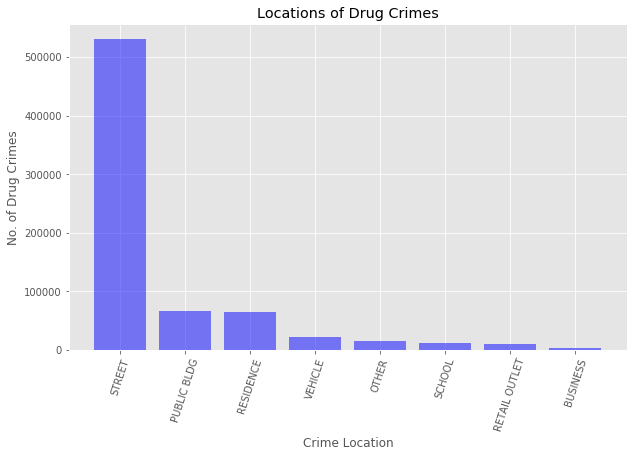

In [93]:

# Assign Variables for plotting  
x_axis = drugs_crime_locations['LocationDescription']
y_axis = drugs_crime_locations['Crime_count']
color = ['blue']

# Set figure size
plt.figure(figsize=(10,6))

# Create a Bar plot  
plt.bar(x_axis, y_axis , color=color, alpha=0.5, align="center")

# Incorporate other chart properties
plt.title("Locations of Drug Crimes")
plt.ylabel("No. of Drug Crimes")
plt.xlabel("Crime Location")
plt.xticks(rotation=72)
plt.grid(True)

plt.show()

### 毒品犯罪与时间关系


In [94]:
drugs_crime_month = pd.DataFrame({"No. of Drug Crimes":drugs_crime_df.groupby(['Month'])['PrimaryType'].count() })

# Reset index and sort values by number of drug crimes
drugs_crime_month = drugs_crime_month.reset_index()
drugs_crime_month = drugs_crime_month.sort_values('No. of Drug Crimes', ascending=False)


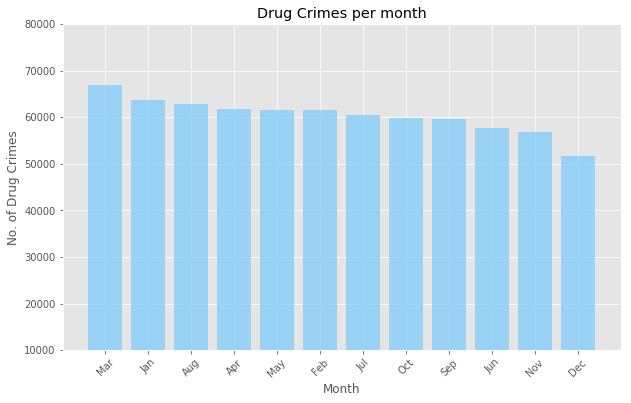

In [96]:

# Set figure size
plt.figure(figsize=(10,6))

# Create a Bar plot  
plt.bar(drugs_crime_month['Month'], drugs_crime_month['No. of Drug Crimes'] , color='lightskyblue', alpha=0.8, align="center")

# Incorporate other chart properties
plt.title("Drug Crimes per month")
plt.ylabel("No. of Drug Crimes")
plt.ylim(10000,80000)
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)

# Save the output
#plt.savefig("Chicago_crimes_Images\\DrugCrimes_months_chicago.png")

plt.show()

In [97]:
times = drugs_crime_df['Time'].value_counts()
drugs_crime_times = pd.DataFrame({"No. of Crimes":drugs_crime_df['Time'].value_counts(), "Time":times.index})

# Change the Time column to a datetime type and format as Hour
drugs_crime_times["Time"] = pd.to_datetime(drugs_crime_times["Time"], format='%X').dt.hour

# Reset Dataframe index
drugs_crime_times = drugs_crime_times.reset_index()
  
# Group dataframe by Time and count of Time
drugs_crime_timess = drugs_crime_times.groupby('Time')['No. of Crimes'].sum()
drugs_crime_time = pd.DataFrame({"No. of Crimes":drugs_crime_timess,
                                "Percentage(%)":(drugs_crime_times.groupby('Time')['No. of Crimes'].sum() /
                                 drugs_crime_timess.sum()) * 100 })

### 毒品犯罪在一天中发生时间分布

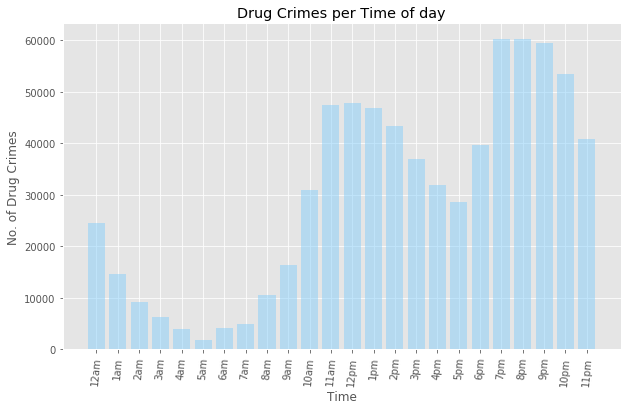

In [98]:

# Assign Variables for Bar plot  
x_axis = ['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm',
          '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']

y_axis = drugs_crime_time['No. of Crimes']

color = 'lightskyblue'

# Set figure size
plt.figure(figsize=(10,6))

# Create a Bar plot  
plt.bar(x_axis, y_axis , color=color, alpha=0.5, align="center")

# Incorporate other chart properties
plt.title("Drug Crimes per Time of day")
plt.ylabel("No. of Drug Crimes")
plt.xlabel("Time")
plt.xticks(rotation=85)
plt.grid(True)

plt.show()

### 犯罪数据街区分布

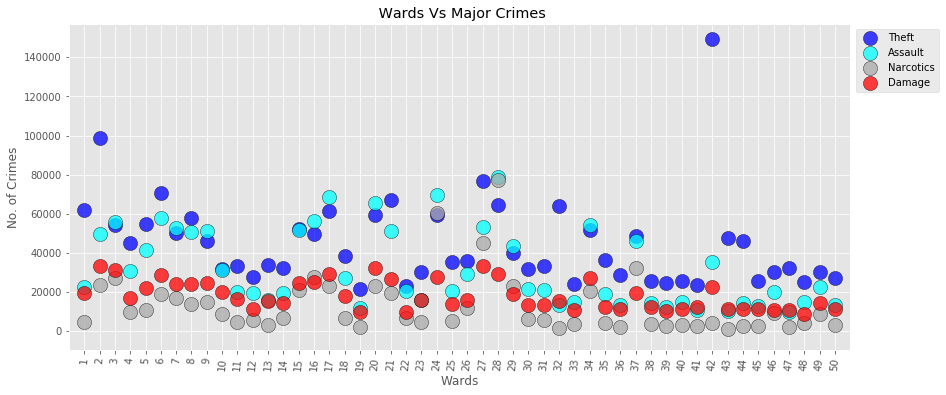

In [99]:
theft_crime_wards = crimes_df.loc[crimes_df['PrimaryType'] == "THEFT & ROBBERY", :]
assault_crime_wards = crimes_df.loc[crimes_df['PrimaryType'] == "ASSAULT", :]
narco_crime_wards = crimes_df.loc[crimes_df['PrimaryType'] == "NARCOTICS", :]
damage_crime_wards = crimes_df.loc[crimes_df['PrimaryType'] == "CRIMINAL DAMAGE", :]

# Group each variable by Ward and count of Primary Type
x_theft_axis = theft_crime_wards.groupby('Ward')['PrimaryType'].count()
x_assault_axis = assault_crime_wards.groupby('Ward')['PrimaryType'].count()
x_narco_axis = narco_crime_wards.groupby('Ward')['PrimaryType'].count()
x_damage_axis = damage_crime_wards.groupby('Ward')['PrimaryType'].count()

# Create a dataframe with the variables above
all_crimes_wards = pd.DataFrame({'Xtheft_axis': x_theft_axis.index, "Theft":x_theft_axis, 'Xassault_axis': x_assault_axis.index, 
                                 "Assault": x_assault_axis, 'XNarco_axis':x_narco_axis.index, "Narcos":x_narco_axis,
                                 "Xdam_axis": x_damage_axis.index, "Damage": x_damage_axis  })
 
                                   
# Set figure size
plt.figure(figsize=(14,6))
# Plot grid
plt.grid(True)

# Create scatter plots for each drug
tef = plt.scatter(all_crimes_wards['Xtheft_axis'] , all_crimes_wards['Theft'], marker="o", facecolors="blue",
                  s= 200, edgecolors="black",alpha=0.75)

ass = plt.scatter(all_crimes_wards['Xassault_axis'] , all_crimes_wards['Assault'], marker="o", facecolors="cyan", 
                  s= 200 ,edgecolors="black",alpha=0.75)

nar = plt.scatter(all_crimes_wards['XNarco_axis'] , all_crimes_wards['Narcos'], marker="o", facecolors="darkgray",
                  s= 200, edgecolors="black",alpha=0.75)

dam = plt.scatter(all_crimes_wards['Xdam_axis'] , all_crimes_wards['Damage'], marker="o", facecolors="red",
                  s= 200, edgecolors="black",alpha=0.75)


# Add other chart elements
plt.xticks(np.arange(1,51,1), rotation=85)
plt.xlim(0,51)
plt.title(" Wards Vs Major Crimes")
plt.xlabel("Wards")
plt.ylabel("No. of Crimes")
plt.legend((tef,ass,nar,dam),('Theft', 'Assault','Narcotics', 'Damage'), scatterpoints=1, 
           bbox_to_anchor = [1.12,1] , ncol=1, fontsize=10)


# Save the output
# plt.savefig("Chicago_crimes_Images\\CrimeWards_chicago.png")

plt.show()

### 毒品类型街区分布

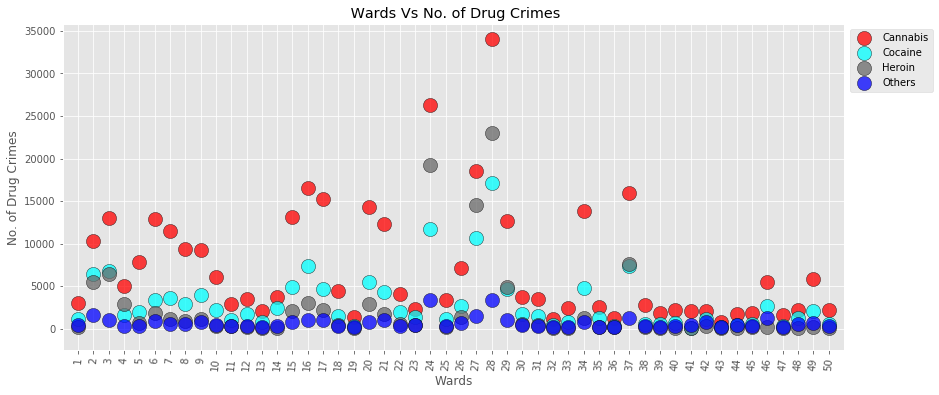

In [101]:
drug_cann_wards = drugs_crime_df.loc[drugs_crime_df['Description'] == "CANNABIS", :]
drug_coca_wards = drugs_crime_df.loc[drugs_crime_df['Description'] == "COCAINE", :]
drug_hero_wards = drugs_crime_df.loc[drugs_crime_df['Description'] == "HEROIN", :]
drug_other_wards = drugs_crime_df.loc[drugs_crime_df['Description'] == "OTHERS", :]

# Group each variable by Ward and count of description
x_cann_axis = drug_cann_wards.groupby('Ward')['Description'].count()
x_coca_axis = drug_coca_wards.groupby('Ward')['Description'].count()
x_hero_axis = drug_hero_wards.groupby('Ward')['Description'].count()
x_others_axis = drug_other_wards.groupby('Ward')['Description'].count()


# Create a dataframe with variables above
drug_crimes_wards = pd.DataFrame({'X-axis':x_cann_axis.index , "Cannabis":x_cann_axis,'X1-axis':x_coca_axis.index,
                                  "Cocaine":x_coca_axis, "X2-axis": x_hero_axis.index,"Heroin": x_hero_axis, 
                                  'X3-axis': x_others_axis.index, "Others": x_others_axis})


# Set figure size
plt.figure(figsize=(14,6))
# Plot grid
plt.grid(True)

# Create scatter plots for each drug
can = plt.scatter(drug_crimes_wards['X-axis'] , drug_crimes_wards['Cannabis'], marker="o", facecolors="red",
                  s= 200, edgecolors="black",alpha=0.75)

coc = plt.scatter(drug_crimes_wards['X1-axis'] , drug_crimes_wards['Cocaine'], marker="o", facecolors="cyan", 
                  s= 200, edgecolors="black", alpha=0.75)

her =plt.scatter(drug_crimes_wards['X2-axis'] , drug_crimes_wards['Heroin'], marker="o", facecolors="dimgray",
                 s= 200, edgecolors="black",alpha=0.75)

oth = plt.scatter(drug_crimes_wards['X3-axis'] , drug_crimes_wards['Others'], marker="o", facecolors="blue",
                  s= 200, edgecolors="black",alpha=0.75)


# Add other chart elements
plt.xticks(np.arange(1,51,1), rotation=85)
plt.xlim(0,51)
plt.title(" Wards Vs No. of Drug Crimes")
plt.xlabel("Wards")
plt.ylabel("No. of Drug Crimes")
plt.legend((can,coc,her,oth),('Cannabis', 'Cocaine','Heroin', 'Others'), scatterpoints=1, 
           bbox_to_anchor = [1.12,1], ncol=1, fontsize=10)


# Save the output
# plt.savefig("Chicago_crimes_Images\\DrugCrimeWards_chicago.png")
plt.show()

In [103]:
import seaborn as sns

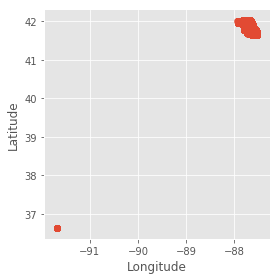

In [105]:
ax = sns.lmplot('Longitude', 'Latitude',
                data= crimes_df[['Longitude','Latitude']],
                fit_reg=False,
                size=4, 
                scatter_kws={'alpha':.1})

In [ ]:
ax = sns.kdeplot(crimes_df[['Longitude','Latitude']],
                 cmap="jet", 
                 bw=.005,
                 #n_levels=10,
                 cbar=True, 
                 shade=False, 
                 shade_lowest=False)
ax.set_xlim(-87.9,-87.5)
ax.set_ylim(41.60,42.05)